# Imports and parameters

In [1]:
from multiprocessing import Pool, cpu_count
import warnings
import astropy.units as u
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt

from PerseusGammaCalibration import perseus_model_library
from PerseusGammaCalibration import perseus_data_library
import minot

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

In [2]:
Nmc         = 100         # Number of Monte Carlo trials
fit_index   = False       # Fit the spectral index profile
mcmc_nsteps = 1000        # number of MCMC points
mcmc_burnin = 200         # number of MCMC burnin points

# Define the cluster model

In [3]:
cluster = perseus_model_library.default_model()
cluster = perseus_model_library.set_magnetic_field_model(cluster, case='Taylor2006')
cluster = perseus_model_library.set_pure_leptonic_model(cluster, ('density', 2.0), 7e-7, -2.0, 0.23*u.GeV)
cluster.Npt_per_decade_integ = 10

# Data

Flux from profile: 46.232446667751816 Jy
Flux from spectrum: 327.0 MHz 327.0 MHz 17.47280078897421 Jy
flux correcction 2.645966564039675


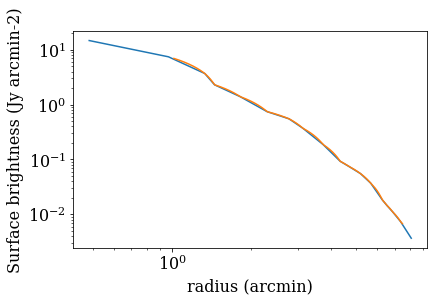

In [4]:
radio_data = perseus_data_library.get_radio_data(cluster.cosmo, cluster.redshift)

# Data initial model comparison

In [5]:
frequency = np.logspace(0,5,50)*u.MHz
radius    = np.logspace(0,3,50)*u.kpc

#----- Spectrum
model_ini_freq, model_ini_spec = cluster.get_synchrotron_spectrum(frequency, 
                                                                  Rmin=radio_data['info']['spec_Rmin'], 
                                                                  Rmax=radio_data['info']['spec_Rmax'], 
                                                                  type_integral='cylindrical', Cframe=False)

#----- Profile
model_ini_rad,  model_ini_prof = cluster.get_synchrotron_profile(radius, freq0=radio_data['info']['prof_freq'], 
                                                                 Cframe=True)

#----- Index
model_ini_idxrad, model_ini_idx1 = cluster.get_synchrotron_profile(radius, freq0=radio_data['info']['idx_freq1'])
model_ini_idxrad, model_ini_idx2 = cluster.get_synchrotron_profile(radius, freq0=radio_data['info']['idx_freq2'])
model_ini_idx = -np.log10((model_ini_idx1/model_ini_idx2).to_value('')) / np.log10((radio_data['info']['idx_freq1']/radio_data['info']['idx_freq2']).to_value(''))

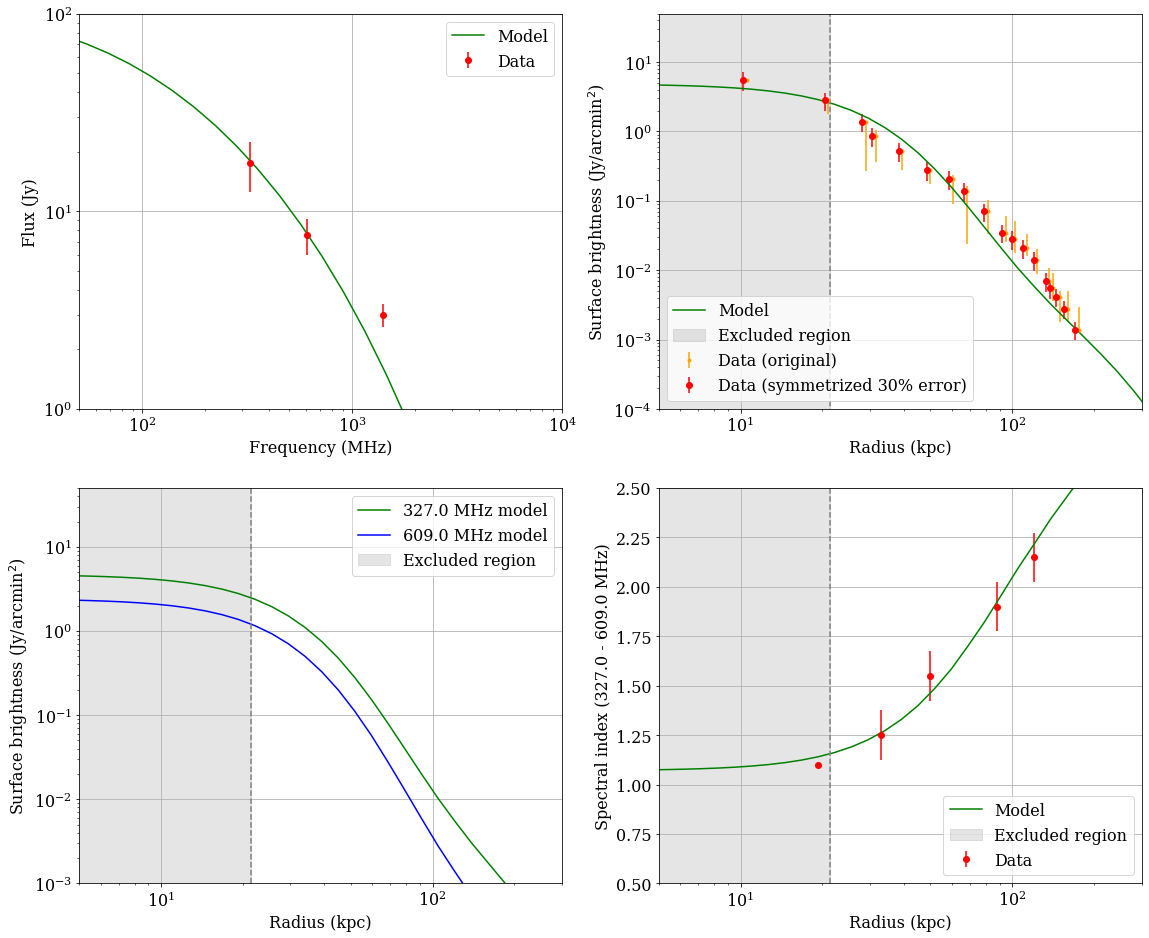

In [6]:
#----- Spectrum
fig = plt.figure(0, figsize=(18, 16))
ax = plt.subplot(221)
plt.errorbar(radio_data['spectrum']['freq'].to_value('MHz'), radio_data['spectrum']['flux'].to_value('Jy'), radio_data['spectrum']['error'].to_value('Jy'),
            marker='o', linestyle='', color='red', label='Data')
plt.plot(model_ini_freq.to_value('MHz'), model_ini_spec.to_value('Jy'), color='green', label='Model')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Flux (Jy)')
plt.xlim(50,10000)
plt.ylim(1,100)
plt.legend()
plt.grid()

#----- Profile
ax = plt.subplot(222)
plt.errorbar(radio_data['profile']['radius'].to_value('kpc')*1.03, radio_data['profile']['flux'].to_value('Jy arcmin-2'), 
             yerr=(radio_data['profile']['error_m'].to_value('Jy arcmin-2'), radio_data['profile']['error_p'].to_value('Jy arcmin-2')),
             marker='.', linestyle='', color='orange', label='Data (original)')
plt.errorbar(radio_data['profile']['radius'].to_value('kpc'), radio_data['profile']['flux'].to_value('Jy arcmin-2'), 
             yerr=radio_data['profile']['error'].to_value('Jy arcmin-2'),
             marker='o', linestyle='', color='red', label='Data (symmetrized 30% error)')
plt.plot(model_ini_rad.to_value('kpc'),  model_ini_prof.to_value('Jy arcmin-2'), color='green', label='Model')
plt.plot([radio_data['info']['prof_Rmin'].to_value('kpc'),radio_data['info']['prof_Rmin'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.plot([radio_data['info']['prof_Rmax'].to_value('kpc'),radio_data['info']['prof_Rmax'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.fill_between([0,radio_data['info']['prof_Rmin'].to_value('kpc')], [0,0], [1e6,1e6], color='grey', alpha=0.2, label='Excluded region')
plt.fill_between([radio_data['info']['prof_Rmax'].to_value('kpc'), np.inf], [0,0], [1e6,1e6], color='grey', alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (kpc)')
plt.ylabel('Surface brightness (Jy/arcmin$^2$)')
plt.xlim(5,300)
plt.ylim(1e-4,50)
plt.legend()
plt.grid()

#----- Profile versus radius
ax = plt.subplot(223)
plt.plot(model_ini_idxrad.to_value('kpc'),  model_ini_idx1.to_value('Jy arcmin-2'), color='green', label=str(radio_data['info']['idx_freq1'].to_value('MHz'))+' MHz model')
plt.plot(model_ini_idxrad.to_value('kpc'),  model_ini_idx2.to_value('Jy arcmin-2'), color='blue', label=str(radio_data['info']['idx_freq2'].to_value('MHz'))+' MHz model')
plt.plot([radio_data['info']['prof_Rmin'].to_value('kpc'),radio_data['info']['prof_Rmin'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.plot([radio_data['info']['prof_Rmax'].to_value('kpc'),radio_data['info']['prof_Rmax'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.fill_between([0,radio_data['info']['prof_Rmin'].to_value('kpc')], [0,0], [1e6,1e6], color='grey', alpha=0.2, label='Excluded region')
plt.fill_between([radio_data['info']['prof_Rmax'].to_value('kpc'), np.inf], [0,0], [1e6,1e6], color='grey', alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (kpc)')
plt.ylabel('Surface brightness (Jy/arcmin$^2$)')
plt.xlim(5,300)
plt.ylim(1e-3,50)
plt.legend()
plt.grid()

#----- Spectral index
ax = plt.subplot(224)
plt.errorbar(radio_data['index']['radius'].to_value('kpc'), radio_data['index']['idx'], yerr=radio_data['index']['error'],
             marker='o', linestyle='', color='red', label='Data')
plt.plot(model_ini_idxrad.to_value('kpc'),  model_ini_idx, color='green', label='Model')
plt.plot([radio_data['info']['idx_Rmin'].to_value('kpc'),radio_data['info']['idx_Rmin'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.plot([radio_data['info']['idx_Rmax'].to_value('kpc'),radio_data['info']['idx_Rmax'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.fill_between([0,radio_data['info']['idx_Rmin'].to_value('kpc')], [0,0], [1e6,1e6], color='grey', alpha=0.2, label='Excluded region')
plt.fill_between([radio_data['info']['idx_Rmax'].to_value('kpc'), np.inf], [0,0], [1e6,1e6], color='grey', alpha=0.2)
plt.xscale('log')
plt.yscale('linear')
plt.xlabel('Radius (kpc)')
plt.ylabel('Spectral index ('+str(radio_data['info']['idx_freq1'].to_value('MHz'))+' - '+str(radio_data['info']['idx_freq2'].to_value('MHz'))+' MHz)')
plt.xlim(5,300)
plt.ylim(0.5,2.5)
plt.legend()
plt.grid()

# MCMC fit

In [7]:
#----- Defines log likelihood
def lnlike(params, cluster, data):
    #--- Priors
    cond1 = params[0]>=0    and params[0]<=1    # X
    cond2 = params[1]>=-5   and params[1]<=5    # eta_CRe1
    cond3 = params[2]>=1e-3 and params[2]<=1e6  # Ecut
    cond4 = True #params[3]>=-3   and params[3]<=-1   # Index
    if cond1 and cond2 and cond3 and cond4:
        
        prof_mod, spec_mod, idx_mod = model(params, cluster, data)
        
        # Profile chi2
        wgood = (data['profile']['radius'] > data['info']['prof_Rmin'])*(data['profile']['radius'] < data['info']['prof_Rmax'])
        prof_chi2 = ((data['profile']['flux'].to_value('Jy arcmin-2')[wgood] - prof_mod.to_value('Jy arcmin-2')[wgood])**2)/data['profile']['error'].to_value('Jy arcmin-2')[wgood]**2

        # Spectrum chi2
        spec_chi2 = ((data['spectrum']['flux'].to_value('Jy') - spec_mod.to_value('Jy'))**2)/data['spectrum']['error'].to_value('Jy')**2

        # Spectral index chi2
        wgood = (data['index']['radius'] > data['info']['idx_Rmin'])*(data['index']['radius'] < data['info']['idx_Rmax'])
        idx_chi2 = ((data['index']['idx'][wgood] - idx_mod[wgood])**2)/data['index']['error'][wgood]**2
        
        # Chi2 tot
        chi2_tot = -0.5*np.nansum(prof_chi2) - 0.5*np.nansum(spec_chi2)
        if fit_index: 
            chi2_tot = chi2_tot - 0.5*np.nansum(idx_chi2)
        
        return chi2_tot
    else:
        #print('Prior conditions are ', cond1, cond2, cond3, cond4)
        return -np.inf

In [8]:
#----- Defines model
def model(params, cluster, data):
    #--- Extract parameters
    CR_X_E   = params[0]
    CR_eta   = params[1]
    CR_Ec    = params[2]
    CR_index = -2 #params[3]
    
    #--- Set parameters
    cluster = perseus_model_library.set_pure_leptonic_model(cluster, 
                                                            ('density', CR_eta), CR_X_E, CR_index, CR_Ec*u.GeV)
    
    #--- Profile
    r_synch, p_synch = cluster.get_synchrotron_profile(data['profile']['radius'], freq0=data['info']['prof_freq'])
    
    #--- Spectrum
    sfreq_bis = np.append(np.array([1]), data['spectrum']['freq'].to_value('MHz'))*u.MHz
    s_synch = cluster.get_synchrotron_spectrum(sfreq_bis, Rmin=data['info']['spec_Rmin'],
                                               Rmax=data['info']['spec_Rmax'], type_integral='cylindrical')[1]
    s_synch = s_synch[1:]
    
    #--- Spectral index
    p_synch1 = cluster.get_synchrotron_profile(data['index']['radius'], freq0=data['info']['idx_freq1'])[1]
    p_synch2 = cluster.get_synchrotron_profile(data['index']['radius'], freq0=data['info']['idx_freq2'])[1]
    i_synch  = -np.log10((p_synch1/p_synch2).to_value('')) / np.log10((data['info']['idx_freq1']/data['info']['idx_freq2']).to_value(''))
        
    return p_synch, s_synch, i_synch

In [9]:
#----- Define the MCMC
par0 = np.array([5e-07, 1.6, 0.2])

param_name = [r'$X_{CRe}$', r'$\eta_{CRe}$', r'$E_{cut}$(GeV)']
ndim, nwalkers, nsteps, burnin = len(par0), 10, mcmc_nsteps, mcmc_burnin
pos = [par0 + par0*1e-1*np.random.randn(ndim) for i in range(nwalkers)]

In [10]:
#----- Define the MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=[cluster, radio_data], pool=Pool(cpu_count()))

#----- Restart from where it is or reset
sampler.reset()

#----- Rune the MCMC
res = sampler.run_mcmc(pos, nsteps, progress=True)

100%|██████████| 1000/1000 [15:55<00:00,  1.05it/s]


In [11]:
#----- Burn in
param_chains = sampler.chain[:, burnin:, :]
lnL_chains = sampler.lnprobability[:, burnin:]

In [12]:
#----- Get the best fit parameters
wbest = (lnL_chains == np.amax(lnL_chains))
param_best = []
for i in range(ndim):
    param_best.append(((param_chains[:,:,i])[wbest])[0])

In [13]:
#----- MC parameters
param_flat = param_chains.reshape(param_chains.shape[0]*param_chains.shape[1],param_chains.shape[2])
Nsample = len(param_flat[:,0])-1
param_MC = np.zeros((Nmc, ndim))
for i in range(Nmc):
    param_MC[i,:] = param_flat[np.random.randint(0, high=Nsample), :] # randomly taken from chains

# Result

### Chains

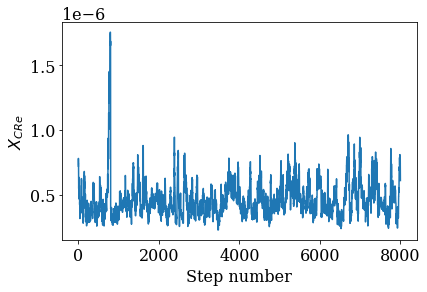

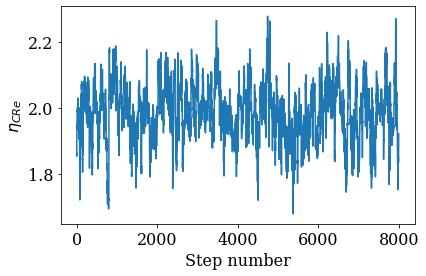

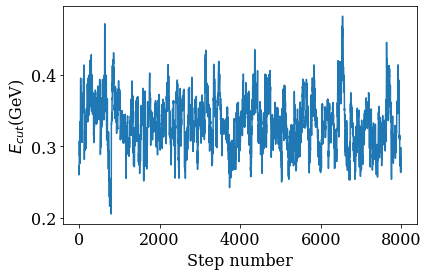

In [14]:
for i in range(ndim):
    plt.figure(i)
    plt.plot((param_chains[:,:,i]).flatten())
    plt.xlabel('Step number')
    plt.ylabel(param_name[i])

### Parameters

In [15]:
print(param_best)

[4.0478798334799264e-07, 2.0102614310178843, 0.3402204865293922]


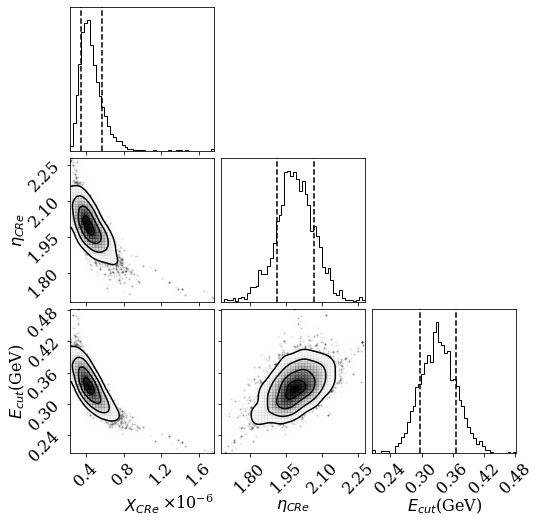

In [16]:
#----- Parameter space
par_flat = param_chains.reshape(param_chains.shape[0]*param_chains.shape[1], param_chains.shape[2])
fig = corner.corner(par_flat, bins=50, color='k', smooth=2, 
                    labels=param_name, quantiles=(0.16, 0.84), use_math_text=True)

### Data versus best-fit

In [17]:
# Best-fit
prof_best, spec_best, idx_best = model(param_best, cluster, radio_data)

In [18]:
# MC sampling
prof_mc = []
spec_mc = []
idx_mc  = []

for imc in range(Nmc):
    prof_mci, spec_mci, idx_mci = model(param_MC[imc,:], cluster, radio_data)
    prof_mc.append(prof_mci)
    spec_mc.append(spec_mci)
    idx_mc.append(idx_mci)

In [19]:
# Limits
prof_u = np.percentile(np.array(prof_mc), 100-(100-68)/2.0, axis=0)*prof_mc[0].unit
prof_d = np.percentile(np.array(prof_mc), (100-68)/2.0, axis=0)*prof_mc[0].unit

spec_u = np.percentile(np.array(spec_mc), 100-(100-68)/2.0, axis=0)*spec_mc[0].unit
spec_d = np.percentile(np.array(spec_mc), (100-68)/2.0, axis=0)*spec_mc[0].unit

idx_u = np.percentile(np.array(idx_mc), 100-(100-68)/2.0, axis=0)
idx_d = np.percentile(np.array(idx_mc), (100-68)/2.0, axis=0)

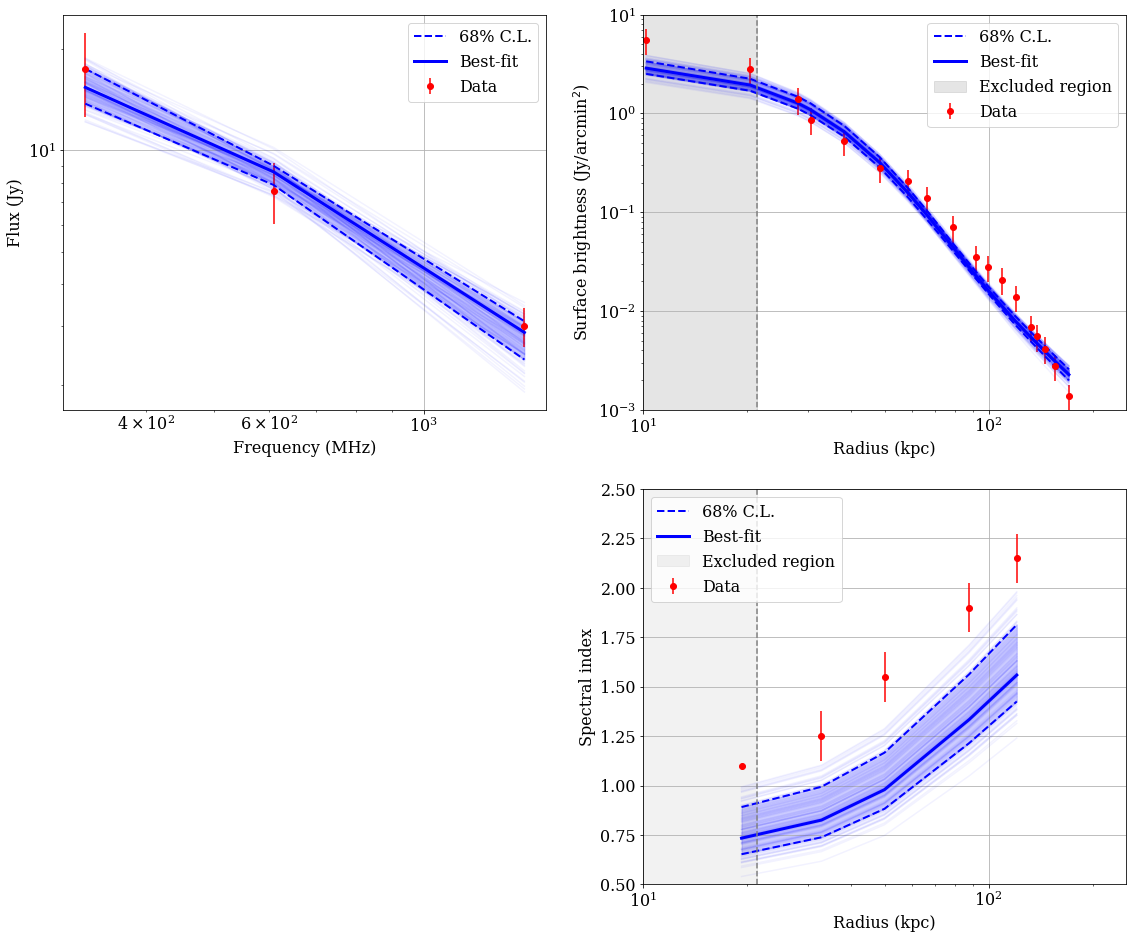

In [20]:
fig = plt.figure(0, figsize=(18, 16))

#----- Spectrum
ax = plt.subplot(221)
# MC
for imc in range(Nmc):
    plt.plot(radio_data['spectrum']['freq'].to_value('MHz'), spec_mc[imc].to_value('Jy'), color='blue', alpha=0.05)

# Limits
plt.plot(radio_data['spectrum']['freq'].to_value('MHz'), spec_u.to_value('Jy'), color='blue', linewidth=2, linestyle='--', label='68% C.L.')
plt.plot(radio_data['spectrum']['freq'].to_value('MHz'), spec_d.to_value('Jy'), color='blue', linewidth=2, linestyle='--')
plt.fill_between(radio_data['spectrum']['freq'].to_value('MHz'), spec_d.to_value('Jy'), spec_u.to_value('Jy'), color='blue', alpha=0.2)

# Best fit and data
plt.plot(radio_data['spectrum']['freq'].to_value('MHz'), spec_best.to_value('Jy'), color='blue', linewidth=3, label='Best-fit')
plt.errorbar(radio_data['spectrum']['freq'].to_value('MHz'), radio_data['spectrum']['flux'].to_value('Jy'), radio_data['spectrum']['error'].to_value('Jy'),
            marker='o', color='red', linestyle='', label='Data')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Flux (Jy)')
plt.legend()
plt.grid()

#----- Profile
ax = plt.subplot(222)
# MC
for imc in range(Nmc):
    plt.plot(radio_data['profile']['radius'].to_value('kpc'), prof_mc[imc].to_value('Jy arcmin-2'), color='blue', alpha=0.05)

# Limits    
plt.plot(radio_data['profile']['radius'].to_value('kpc'), prof_u.to_value('Jy arcmin-2'), color='blue', linewidth=2, linestyle='--', label='68% C.L.')
plt.plot(radio_data['profile']['radius'].to_value('kpc'), prof_d.to_value('Jy arcmin-2'), color='blue', linewidth=2, linestyle='--')
plt.fill_between(radio_data['profile']['radius'].to_value('kpc'), prof_d.to_value('Jy arcmin-2'), prof_u.to_value('Jy arcmin-2'), color='blue', alpha=0.2)


# Best and data
plt.plot(radio_data['profile']['radius'].to_value('kpc'), prof_best.to_value('Jy arcmin-2'), color='blue', linewidth=3, label='Best-fit')
plt.errorbar(radio_data['profile']['radius'].to_value('kpc'), radio_data['profile']['flux'].to_value('Jy arcmin-2'), 
             yerr=radio_data['profile']['error'].to_value('Jy arcmin-2'),
             marker='o', linestyle='', color='red', label='Data')

plt.plot([radio_data['info']['prof_Rmin'].to_value('kpc'),radio_data['info']['prof_Rmin'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.plot([radio_data['info']['prof_Rmax'].to_value('kpc'),radio_data['info']['prof_Rmax'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.fill_between([0,radio_data['info']['prof_Rmin'].to_value('kpc')], [0,0], [1e6,1e6], color='grey', alpha=0.2, label='Excluded region')
plt.fill_between([radio_data['info']['prof_Rmax'].to_value('kpc'), np.inf], [0,0], [1e6,1e6], color='grey', alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (kpc)')
plt.ylabel('Surface brightness (Jy/arcmin$^2$)')
plt.xlim(10,250)
plt.ylim(1e-3,1e1)
plt.legend()
plt.grid()

#----- Spectral index
ax = plt.subplot(224)
# MC
for imc in range(Nmc):
    plt.plot(radio_data['index']['radius'].to_value('kpc'), idx_mc[imc], color='blue', alpha=0.05)

# Limits
plt.plot(radio_data['index']['radius'].to_value('kpc'), idx_u, color='blue', linewidth=2, linestyle='--', label='68% C.L.')
plt.plot(radio_data['index']['radius'].to_value('kpc'), idx_d, color='blue', linewidth=2, linestyle='--')
plt.fill_between(radio_data['index']['radius'].to_value('kpc'), idx_d, idx_u, color='blue', alpha=0.2)

# Best and data    
plt.plot(radio_data['index']['radius'].to_value('kpc'), idx_best, color='blue', linewidth=3, label='Best-fit')
plt.errorbar(radio_data['index']['radius'].to_value('kpc'), radio_data['index']['idx'], yerr=radio_data['index']['error'],
             marker='o', linestyle='', color='red', label='Data')

plt.plot([radio_data['info']['idx_Rmin'].to_value('kpc'),radio_data['info']['idx_Rmin'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.plot([radio_data['info']['idx_Rmax'].to_value('kpc'),radio_data['info']['idx_Rmax'].to_value('kpc')], [0,1e6], linestyle='--', color='grey')
plt.fill_between([0,radio_data['info']['idx_Rmin'].to_value('kpc')], [0,0], [1e6,1e6], color='grey', alpha=0.1, label='Excluded region')
plt.fill_between([radio_data['info']['idx_Rmax'].to_value('kpc'), np.inf], [0,0], [1e6,1e6], color='grey', alpha=0.1)
plt.xscale('log')
plt.yscale('linear')
plt.xlabel('Radius (kpc)')
plt.ylabel('Spectral index')
plt.xlim(10,250)
plt.ylim(0.5,2.5)
plt.legend()
plt.grid()

# Implications for the gamma-rays

In [21]:
energy = np.logspace(-2,6,100)*u.GeV
radius = np.logspace(0,4,100)*u.kpc

In [22]:
# Best-fit
cluster = perseus_model_library.set_pure_leptonic_model(cluster, 
                                                        ('density', param_best[1]), 
                                                        param_best[0], -2, param_best[2]*u.GeV)
    
E, dN_dEdSdt = cluster.get_ic_spectrum(energy=np.logspace(-2,6,100)*u.GeV, Rmin=None, Rmax=None,
                                       type_integral='cylindrical', Rmin_los=None, NR500_los=5.0)
r, dN_dSdtdO = cluster.get_ic_profile(radius=np.logspace(0,4,100)*u.kpc, Emin=50*u.GeV, Emax=100*u.TeV, 
                                      Energy_density=False, Rmin_los=None, NR500_los=5.0)

In [23]:
# Monte Carlo
prof_g_mc = []
spec_g_mc = []

for imc in range(Nmc):
    cluster = perseus_model_library.set_pure_leptonic_model(cluster, 
                                                        ('density', param_MC[imc,1]), 
                                                        param_MC[imc,0], -2, param_MC[imc,2]*u.GeV)

    spec_g_mci = cluster.get_ic_spectrum(energy, Rmin=None, Rmax=cluster.R500,type_integral='cylindrical',
                                         Rmin_los=None, NR500_los=5.0)[1]

    prof_g_mci = cluster.get_ic_profile(radius, Emin=50*u.GeV, Emax=100*u.TeV, 
                                        Energy_density=False, Rmin_los=None, NR500_los=5.0)[1]
    prof_g_mc.append(prof_g_mci)
    spec_g_mc.append(spec_g_mci)

In [24]:
# Limits
dN_dEdSdt_u = np.percentile(np.array(spec_g_mc), 100-(100-68)/2.0, axis=0)*spec_g_mc[0].unit
dN_dEdSdt_d = np.percentile(np.array(spec_g_mc), (100-68)/2.0, axis=0)*spec_g_mc[0].unit

dN_dSdtdO_u = np.percentile(np.array(prof_g_mc), 100-(100-68)/2.0, axis=0)*prof_g_mc[0].unit
dN_dSdtdO_d = np.percentile(np.array(prof_g_mc), (100-68)/2.0, axis=0)*prof_g_mc[0].unit

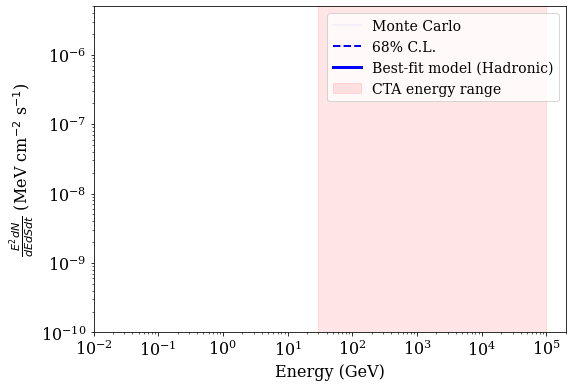

In [25]:
#----- Spectrum
fig = plt.figure(0, figsize=(8, 6))
# MC
for imc in range(Nmc):
    if imc == 0:
        plt.plot(E.to_value('GeV'), (E**2*spec_g_mc[imc]).to_value('MeV cm-2 s-1'), color='blue', alpha=0.05, label='Monte Carlo')
    else:
        plt.plot(E.to_value('GeV'), (E**2*spec_g_mc[imc]).to_value('MeV cm-2 s-1'), color='blue', alpha=0.05)

# Limits
plt.plot(E.to_value('GeV'), (E**2*dN_dEdSdt_u).to_value('MeV cm-2 s-1'), color='blue', linewidth=2, linestyle='--', label='68% C.L.')
plt.plot(E.to_value('GeV'), (E**2*dN_dEdSdt_d).to_value('MeV cm-2 s-1'), color='blue', linewidth=2, linestyle='--')
plt.fill_between(E.to_value('GeV'), (E**2*dN_dEdSdt_u).to_value('MeV cm-2 s-1'), (E**2*dN_dEdSdt_d).to_value('MeV cm-2 s-1'), color='blue', alpha=0.2)

# Best fit
plt.plot(E.to_value('GeV'), (E**2*dN_dEdSdt).to_value('MeV cm-2 s-1'), color='blue', linewidth=3, label='Best-fit model (Hadronic)')

plt.fill_between([30, 100e3], [0,0], [1e6,1e6], color='red', alpha=0.1, label='CTA energy range')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (GeV)')
plt.ylabel(r'$\frac{E^2 dN}{dEdSdt}$ (MeV cm$^{-2}$ s$^{-1}$)')
plt.xlim(1e-2, 2e5)
plt.ylim(1e-10, 5e-6)
plt.legend(fontsize=14)

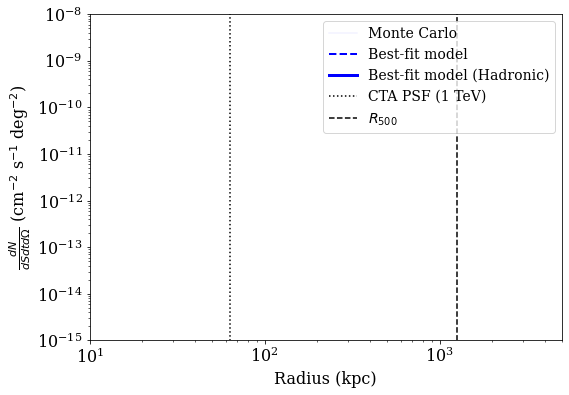

In [26]:
#----- Profile
fig = plt.figure(0, figsize=(8, 6))
# MC
for imc in range(Nmc):
    if imc == 0:
        plt.plot(r.to_value('kpc'), (prof_g_mc[imc]).to_value('cm-2 s-1 deg-2'), color='blue', alpha=0.05, label='Monte Carlo')
    else:
        plt.plot(r.to_value('kpc'), (prof_g_mc[imc]).to_value('cm-2 s-1 deg-2'), color='blue', alpha=0.05)

# Limits
plt.plot(r.to_value('kpc'), (dN_dSdtdO_u).to_value('cm-2 s-1 deg-2'), color='blue', linewidth=2, linestyle='--', label='Best-fit model')
plt.plot(r.to_value('kpc'), (dN_dSdtdO_d).to_value('cm-2 s-1 deg-2'), color='blue', linewidth=2, linestyle='--')
plt.fill_between(r.to_value('kpc'), (dN_dSdtdO_u).to_value('cm-2 s-1 deg-2'), (dN_dSdtdO_d).to_value('cm-2 s-1 deg-2'), color='blue', alpha=0.2)
  
# Best-fit
plt.plot(r.to_value('kpc'), (dN_dSdtdO).to_value('cm-2 s-1 deg-2'), color='blue', linewidth=3, label='Best-fit model (Hadronic)')

plt.vlines((0.05*u.deg*cluster.cosmo.kpc_proper_per_arcmin(cluster.redshift)).to_value('kpc'), 0,1, linestyle=':', color='k', label='CTA PSF (1 TeV)')
plt.vlines(cluster.R500.to_value('kpc'), 0,1, linestyle='--', color='k', label='$R_{500}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Radius (kpc)')
plt.ylabel(r'$\frac{dN}{dSdtd\Omega}$ (cm$^{-2}$ s$^{-1}$ deg$^{-2}$)')
plt.xlim(10,5e3)
plt.ylim(1e-15,1e-8)
plt.legend(fontsize=14)